# 1. Introduction

Apart from a few worked examples in the textbook, it is quite difficult to obtain analytic solutions to the Schrödinger Equation. The situation only gets worse when the underlying phase space grows in dimension, thus posing a serious problem for researchers.

With the advent of electronic computeres, numerical methods that target this problem began its development. This has given rise to two Nobel Prizes in Chemistry --- the 1998 one for the **density functional theory (DFT)** and the 2013 one for **multiscale models**.[1] The **Quantum Monte Carlo** methods family is also widely used in research, particularly on massively parallel computers. For few-body systems, direct integration of the time-dependent Shrödinger Equation is also used to increase the simulation accuracy.

To get a glimpse of these numerical methods, we begin by considering the simplest case of all: the one dimensional steady state Schrödinger Equation for a single particle.

# 2. Scattering state

## 2.1 Direct integration method

In simulating a 1D scattering state, we usually fix the energy $E$ and look at the relation between the incident, reflected and transmitted waves. In particular, the steady state Schrödinger Equation is now an ordinary differential equation (ODE):

$$-\frac{1}{2}\frac{\partial^2 \phi}{\partial x^2} + V(x)\phi(x) = E\phi(x)\quad(1)$$

(we choose the **atomic units**, where $\hbar = 1$ and $m = 1$). Assume that the incident wave travels in the $-x$ direction (this is the opposite of what most textbooks use --- we'll see why in a moment), then for the region where $V(x) = 0$, the wavefunction takes the form:

$$ \phi(x) = \Big\{\begin{array}{ll}
Ae^{-ikx} + Be^{ikx}& x > 0 \\ 
Ce^{-ikx} & x < 0 \end{array} \quad (2)$$

where $k=\sqrt{2E}$ is the wavenumber and $|B/A|^2$ and $|C/A|^2$ represents respectively the reflection and transmittion coefficient $R$ and $T$.

Recall that for a second-order ODE to be well-defined, we need an initial condition $(\phi(x_0), \phi'(x_0))$. It so happens that in the transmitted region ($x<0$), we have $\phi'(x_0) / \phi(x_0) = -ik$. Since multiplying the wavefunction by an arbitrary scalar doesn't change the physics, we can always choose $\phi(x_0) = 1$ and subsequently $\phi'(x_0) = -ik$. This gives rise to the **method of direct integration** for 1D scattering state:

1. Choose $x_0 < 0$ so that $V(x_0)$ is sufficiently close to 0.

2. Integrate the ODE (1) with the initial condition $\phi(x_0) = 1, \, \phi'(x_0) = -ik$

3. Extract $A$, $B$ and $C$ from the calculated $\phi(x)$ (e.g via Fourier transform) and proceed to calculate $R$ and $T$

The integrator in step 2 can be any general complex-valued ODE solver. In this notebook we use the ZVode integrator form SciPy ([link](http://www.netlib.org/ode/zvode.f)). There do exists an algorithm specifically tailored to solving the Schrödinger Equation: the Numerov algorithm. For a reference, see [2][3]. The previous choice of assuming $-x$ direction of the incident wave is justifield by the fact that most ODE integrators prefer to proceed in the $+x$ direction.

In [1]:
import numpy as np
import scipy
import matplotlib
from scipy import linalg
from scipy.integrate import quad, ode
import matplotlib.pyplot as plt
%matplotlib inline

First, let's define some potential functions:

In [2]:
def gaussian(center, height, sigma):
    '''Gaussian Potential'''
    return lambda x : height * np.exp(-(x - center)**2/(2 * sigma**2))

def square(height, l, r):
    '''Square Well Potential'''
    def V(x):
        if l < x < r:
            return height
        else:
            return 0.0
    return V

The following code implements the direct integration method:

In [3]:
def scattering_state(E, V, xs):
    '''
    Direct integration for 1D scattering state using the ZVode integrator
    
    Parameters
    ==========
    `E`: energy
    `V`: potential function
    `xs`: points to record where `xs[0]` is the starting point.
    
    Returns
    =======
    `ϕs`: calculated value of ϕ on the points `xs`
    '''
    ϕs = np.zeros(len(xs), dtype=complex)
    k = np.sqrt(2 * E)
    ϕ0 = 1; ϕ0_prime = -1j * k; ϕs[0] = ϕ0
    
    u0 = np.array([ϕ0, ϕ0_prime]) # inital value
    rhs = lambda x, u: np.array([u[1], 2 * (V(x) - E) * u[0]])
    eq = ode(rhs).set_integrator("zvode").set_initial_value(u0, xs[0])
    
    for i in range(1, len(xs)):
        eq.integrate(xs[i])
        ϕs[i] = eq.y[0]
    return ϕs

## 2.2 Scattering of the $\delta$ barrier

The $\delta$ barrier $V(x) = \delta(x)$ provides a simple example for the quantum tunneling phenomenon. The analytic result for $E = 1$ is:

$$\begin{array}{l}|T|^2 = \frac{1}{1 + \frac{1}{2E}} = 2/3 \\
|R|^2 = 1 - |T|^2 = 1/3 \end{array} \quad (3)$$

To simulate the $\delta$ barrier using the direct integration method, we use a series of Gaussian potentials to approximate the $\delta$ function:

$$\frac{1}{\sqrt{2\pi}\sigma}\exp(-\frac{x^2}{2\sigma^2}) \rightarrow \delta(x) \quad(\sigma \rightarrow 0) \quad (4)$$

In [4]:
E = 1
σs = [1, 0.5, 0.2, 0.1, 0.05, 0.02]
Vs = [gaussian(0, 1 / (np.sqrt(2*np.pi) * σ), σ) for σ in σs]

The numerical results for each value of $\sigma$ is plotted below:

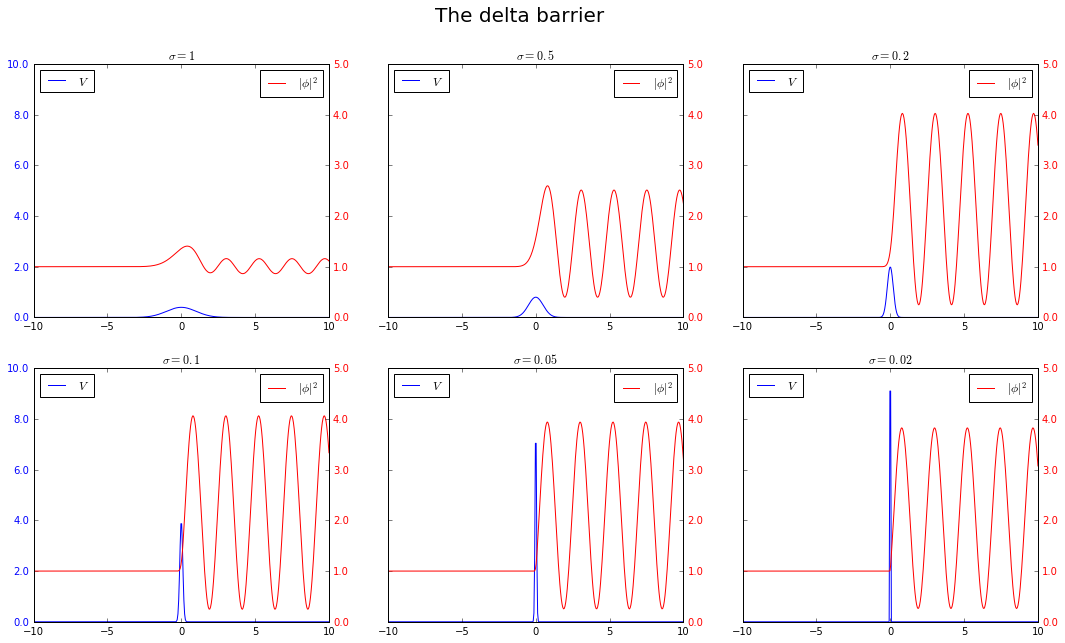

In [5]:
N = 400
xs = np.linspace(-10, 10, N) # Recorded points
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18,10), sharey=True)
for i, σ in enumerate(σs):
    V = Vs[i]
    ϕs = scattering_state(E, V, xs)
    # Plotting routines
    ax_V = axes[i//3, i%3]
    ax_ϕ = ax_V.twinx()
    ax_V.plot(xs, [V(x) for x in xs], 'b', label=r'$V$')
    ax_ϕ.plot(xs, abs(ϕs)**2, 'r', label=r'$|\phi|^2$')
    ax_ϕ.set_ylim(0, 5.0)
    ax_V.set_yticklabels(ax_V.get_yticks(), color='b')
    ax_ϕ.set_yticklabels(ax_ϕ.get_yticks(), color='r')
    ax_V.legend(loc=2)
    ax_ϕ.legend()
    ax_V.set_title(r'$\sigma={}$'.format(σ))
fig.suptitle('The delta barrier', fontsize=20)
# plt.savefig('delta_barrier.png')

A crude estimation of $S$ and $T$ can be carried out as follows: in the transmitted wave region ($x < 0$), it's easy to see $|C| \approx 1$. As for the incident/reflected wave region ($x > 1$), the superposition maxima and minima correspond to the value of $|A| + |B|$ and $|A| - |B|$:

In [6]:
ϕs = scattering_state(E, Vs[-1], xs)
print("|A| + |B| = {:.3f}".format(np.max(np.abs(ϕs))))
print("|A| - |B| = {:.3f}".format(np.min(np.abs(ϕs))))

|A| + |B| = 1.955
|A| - |B| = 0.512


Thus $|A| \approx 1.234$ and $|B| \approx 0.722$, which gives $|T| \approx 0.657$ and $|R| \approx 0.342$. This is close to the theoretical value predicted in (3).

# 3. Bound state - finite difference scheme

## 3.1 Discretization of the Schrödinger Equation

The energy level $E_n$ of bound states are usually not know a priori. Although the methods discussed in Section 2 can still be adapted in this situation, for most choice of $E$ the wavefunction will diverge. We are then forced to tune the value of $E$ incrementally until the solution coverges. This is the so-called "shooting method".

A different approach is to discrete the phase space and approximate derivatives with finite differences, giving rise to the **finite difference (FD)** scheme. We proceed as follows:

1. Choose solution domain $[a, b]$ large enough so that most of the particle density is concentrated within the region. Then fix $\phi(a) = \phi(b) = 0$

2. Discretization of space: let $x_k = a + k\Delta,\,(k = 0, 1, \ldots, N + 1)$ with $\Delta = (b - a) / (N + 1)$. The wave function is now represented by its value on the grid points $\Phi := (\phi(x_1)\ldots\phi(x_N))^T$

3. Discretization of the Hamiltonian: Taylor expansion gives the approximation $\phi(x_{k-1}) - 2\phi(x_k) + \phi(x_{k+1}) \approx \phi''(x_k)\Delta^2$. Substituting this into (1) gives the matrix equation

$$ \mathrm{H}\Phi = E\Phi \quad (5)$$
where $$\mathrm{H} = \frac{1}{2\Delta}\begin{pmatrix}
2 & -1 & & & \\
-1 & 2 & -1 & & \\
& \ddots & \ddots & \ddots& \\
& & -1 & 2 & -1 \\
& & & -1 & 2
\end{pmatrix} + diag\{V(x_1),\ldots,V(x_N)\}$$

Solving the matrix eigenequation gives the approximate energy levels $E_n$ and eigenvector $\Phi_n$, which could be used to construct the eigen-wavefunctions via interpolation.

In [7]:
def Laplacian_fd(N, Δ):
    '''
    The discretized Laplacian operator
    '''
    uu = np.diag(np.ones(N - 1), 1)
    dd = np.diag(-2 * np.ones(N))
    ll = np.diag(np.ones(N - 1), -1)
    return (1/Δ**2) * (uu + dd + ll)

def Hamiltonian_fd(V, a, b, N):
    '''
    The discretized Hamiltonian
    '''
    Δ = (b - a) / (N + 1)
    xx = np.linspace(a, b, N + 2)[1:-1]
    vv = np.array([V(x) for x in xx])
    return -Laplacian_fd(N, Δ) / 2 + np.diag(vv)

Code for carrying out the finite difference scheme:

In [8]:
def finite_difference(V, a, b, N):
    '''
    Solve bound states using the finite difference scheme
    
    Parameters
    ==========
    `V`: the potential funcion
    `a`, `b`: endpoint of the solution region
    `N`: number of grid points (excluding `a` and `b`)
    
    Returns
    =======
    `Es`: the energy levels, sorted from low to high
    `ϕs`: value of the wavefunction on the grid points (including `a` and `b`)
    `xs`: the grid points (including `a` and `b`)
    '''
    Δ = (b - a) / (N + 1)
    xs = np.linspace(a, b, N + 2)
    H = Hamiltonian_fd(V, a, b, N)
    Es, ϕs = linalg.eigh(H) # routine for calculating eigenvalues and eigenvectors
    # Post processing
    # The eigenvectors are in default complex, but we know from Hermitian property they are all real
    ϕs = np.real(ϕs)
    # Normalize the eigenvectors according to the L2 norm on [a, b]
    ϕs /= np.sqrt(Δ)
    # Add the boundary values
    n_eigs = len(Es)
    boundary = np.zeros(n_eigs)
    ϕs = np.row_stack((boundary, ϕs, boundary))
    return Es, ϕs, xs

## 3.2 The infinite well using FD

The well-known result for particles in an infinite potential well at $[0, 1]$ is:

$$\phi_n(x) = \sqrt{2}\sin(n\pi x),\quad E_n = \frac{n^2\pi^2}{2} \quad (6)$$

In [9]:
def ϕ_theory(n):
    return lambda x : np.sqrt(2) * np.sin(n * np.pi * x)

Now we calculate and plot the FD results ($N = 20$):

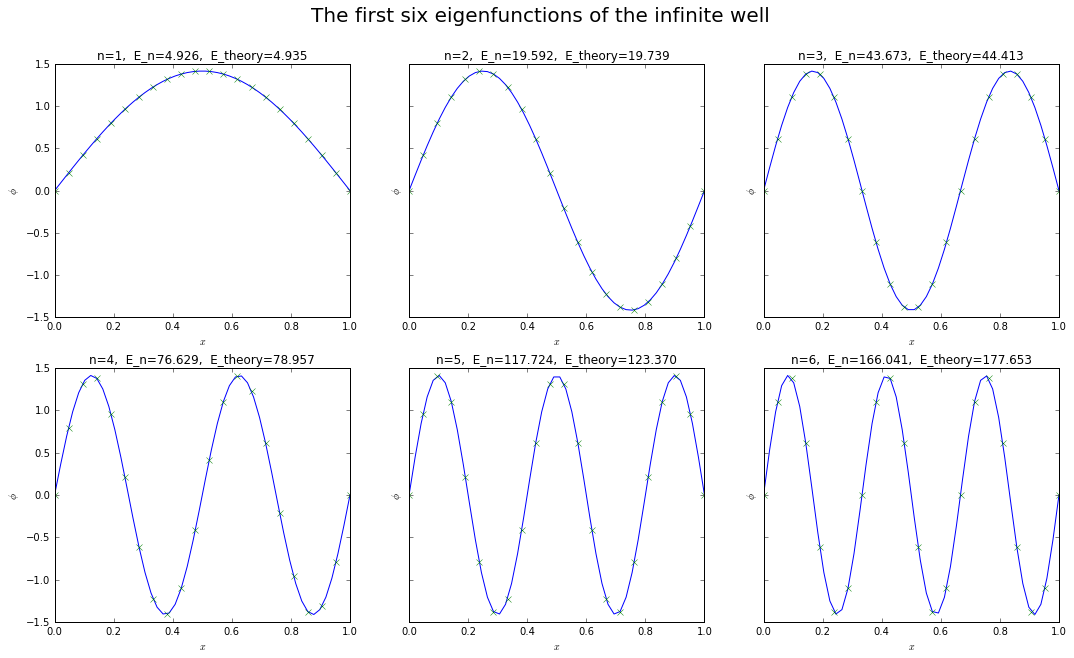

In [10]:
V = lambda x : 0
N = 20
Es, ϕs, xs = finite_difference(V, 0, 1, N)
xs_theory = np.linspace(0, 1, 50)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10), sharey=True)
for i in range(6):
    ax = axes[i//3, i%3]
    n = i + 1
    En = Es[i]
    ϕn = ϕs[:,i]
    # Flip the sign of ϕ to match the theoretical results
    if ϕn[1] < 0:
        ϕn *= -1
    ϕn_theory = ϕ_theory(n)
    ax.plot(xs_theory, [ϕn_theory(x) for x in xs_theory])
    ax.plot(xs, ϕn, 'x')
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$\phi$')
    ax.set_title('n={0},  E_n={1:.3f},  E_theory={2:.3f}'.format(n, En, n**2 * np.pi**2 / 2))
fig.suptitle('The first six eigenfunctions of the infinite well', fontsize=20)
# plt.savefig('eigenfunction_fd.png')

A key observation is that the higher the energy level $n$ goes, the larger the discreptancy between the calculated and theoretical energy value. This is because discretization "drops out" high-frequency information of the wavefunction, which is captured by the higher-level modes. In particular, there's no way to obtain information for energy levels $\ge N$, since a rank-$N$ matrix equation can yield at most $N$ eigenvalues.

To see the trend more clearly, we change the number of grid points $N$ and plot the energy levels:

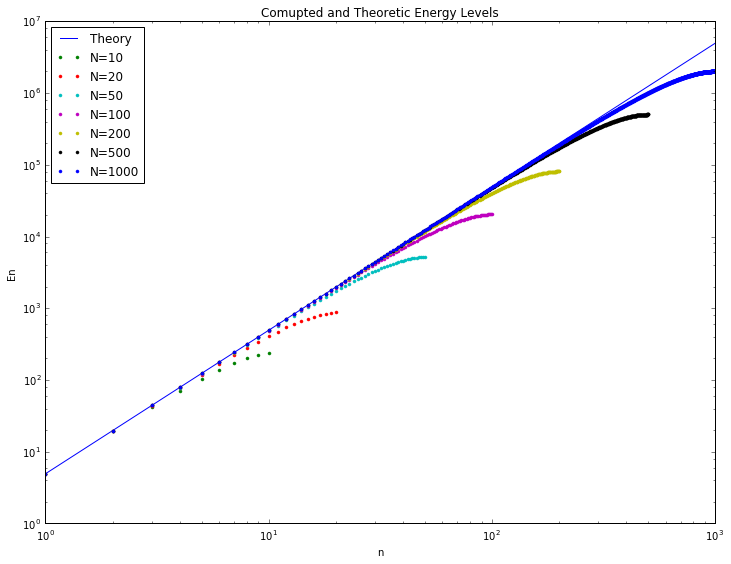

In [11]:
V = lambda x : 0
Ns = [10, 20, 50, 100, 200, 500, 1000]
ns = np.arange(1, 1001)
fig = plt.figure(figsize=(12, 9))
plt.plot(ns, np.pi**2 / 2 * ns**2, label='Theory')
for i, N in enumerate(Ns):
    Es, _, _ = finite_difference(V, 0, 1, N)
    plt.plot(np.arange(1, len(Es) + 1), Es, '.', label='N={}'.format(N))
plt.semilogx()
plt.semilogy()
plt.legend(loc=2)
plt.xlabel('n')
plt.ylabel('En')
plt.title('Comupted and Theoretic Energy Levels')
# plt.savefig('energy_fd.png')

Such a trend is ubiquitous for all bound states algorithms: the higher an enery level you want to calculate, the more computational power you need.

## 3.3 Remarks regarding FD

Finite difference algorithms are extremely easy to implement. They are also quite easily generalized to higher dimensions or the time-dependent Shrödinger Equation. However, as the number of grid points grows exponentially to the dimension $d$, it is seldomly applied to multi-body dynamics. Nevertheless, the concept of "discretizing space & the Hamiltonian" is the foundation of many sophisticated algorithms.

# 4. Bound state - variational method

## 4.1 Alternate form of the Schrödinger Equation

The variational method began by finding a complete basis $\{\psi_n(x)\}$ for the Hilbert space (for the moment, we shall assume them to be orthonormal). It then considers the set of trial functions constructed using only the first $N$ of the basis vectors. According to the Ritz variational principle, the function that best approximate an eigenfunction is one that satisfies the **weak form** of the Schrödinger Equation:

$$ \langle \psi_i | \hat{\mathrm{H}} - E | \phi \rangle = 0 \,\, \mathrm{for} \,\, i = 1,2,\ldots,N \quad (7)$$

which is equivalent to the matrix equation

$$ \mathrm{H}\mathrm{C} = E\mathrm{C} \quad (8)$$

where $\mathrm{H}_{ij} = \langle \psi_i | \hat{\mathrm{H}} | \psi_j\rangle$ and $\phi(x) = \sum_{i=1}^N C_i\psi_i(x)$. Solving for (8) yields the approximate energy levels and the corresponding coefficients, which can then be used to reconstruct the trial function.

The variational method excels in situations with high symmetry (e.g electron orbits inside an atom), where clever choice of basis functions can speed up the computation. It is also the basis for the Quantum Monte Carlo methods.

## 4.2 A "concave bottle" potential well

As an application of the variational method, consider a modified square well potential with a "cusp" at its center. Mathematically the potential function is:

$$ V(x) = \Big\{\begin{array}{ll}
50 e^{-200(x-0.5)^2} & 0 < x < 1 \\
0 & \mathrm{otherwise} \end{array} \quad (9) $$

The eigenfunctions of the unmodified well $ \psi_n(x) = \sqrt{2}\sin(n\pi x)  \quad n = 1,2,\ldots$ is chosen to be our basis functions.

In [12]:
def ψ(n):
    '''
    The basis functions
    '''
    return lambda x : np.sqrt(2) * np.sin(n * np.pi * x)

def Hamiltonian_var(V, N):
    '''
    Construct the rank-N Hamiltonian matrix from a given potential V nonzero on [0, 1]
    '''
    H = np.zeros((N, N))
    for i in range(N):
        for j in range(i):
            func = lambda x : V(x) * ψ(i+1)(x) * ψ(j+1)(x)
            H[i, j] = quad(func, 0, 1)[0]
            H[j, i] = H[i, j]
        # Special processing for diagonal elements
        func = lambda x : V(x) * ψ(i+1)(x)**2
        H[i, i] = ((i+1) * np.pi)**2/2 + quad(func, 0, 1)[0]
    return H

The code for the variational method is very simple:

In [13]:
def var_method(V, N):
    '''
    Returns
    =======
    `Es`: energy levels, sorted from low to high
    `cs`: the corresponding coefficients
    '''
    H = Hamiltonian_var(V, N)
    Es, cs = linalg.eigh(H)
    return Es, cs

Let's see the variational prediction of the new ground state:

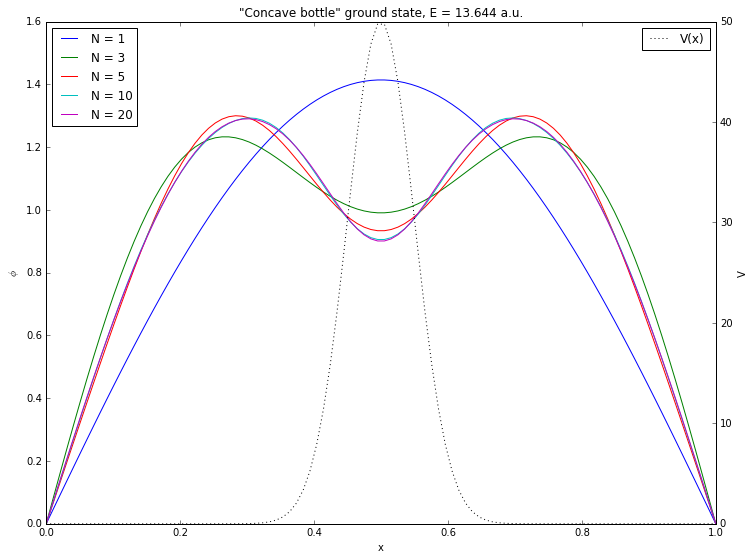

In [14]:
V = gaussian(0.5, 50, 0.05)
Ns = [1, 3, 5, 10, 20]
xs = np.linspace(0, 1, 100)
plt.figure(figsize=(12, 9))
for N in Ns:
    Es, cs = var_method(V, N)
    # Only the ground state
    E1 = Es[0]
    c1 = cs[:,0]
    ϕ1 = lambda x : np.sum([ck * ψ(k+1)(x) for k, ck in enumerate(c1)])
    ϕ1s = np.array([ϕ1(x) for x in xs])
    if ϕ1s[1] < 0:
        ϕ1s *= -1
    plt.plot(xs, ϕ1s, '-', label='N = {}'.format(N))
plt.legend(loc=2)
plt.xlabel('x')
plt.ylabel('$\phi$')
plt.title('"Concave bottle" ground state, E = {:.3f} a.u.'.format(Es[0]))
ax_V = plt.gca().twinx()
ax_V.plot(xs, [V(x) for x in xs], ':k', label='V(x)')
ax_V.legend()
ax_V.set_ylabel('V')
# plt.savefig('var_method.png')

Intuitively, the Gaussian potential should decrease the particle density in the central region, which is confirmed by the numerical results. Also note the result for $N = 20$ is almost identical to $N = 10$, which is remarkable. In general, only a few basis functions is needed if the only thing of interest is the ground state. As usual, more functions are needed if we wish to resolve higher energy states.

## 4.3 Remarks regarding the variational method

In actual usage, we can loosen the requirement that the basis functions $\psi_n(x)$ be orthornormal. The general case of an arbitrary basis gives rise to the generalized eigenvalue problem

$$ \mathrm{H}\mathrm{C} = E\mathrm{S}\mathrm{C} $$

where $\mathrm{S}_{ij} := \langle \psi_i | \psi_j \rangle$ is the metric matrix. The generalized eigenvalue problem can also be solved with ease using existing numerical linear algebra packages. For example, the finite element method uses B-splines as basis functions.

# References

[1] [*Nobel Focus: Chemistry by Computer*, Phys. Rev. Focus 2, 19](http://physics.aps.org/story/v2/st19)

[2] Anders W. Sandvik, *Numerical Solutions of the Schrodinger Equation*, PY 502, Computational Physics, Fall 2015 (Boston University)

[3] Philippe de Forcrand, Matthias Troyer, *Computational Quantum Physics*, ETH Zürich, SS 2008

[4] [*Numerical solution to Schrödinger equation - eigenvalues*, Physics StackExchange](physics.stackexchange.com/questions/170546/numerical-solution-to-schrödinger-equation-eigenvalues)

In [15]:
import sys
print("Python version = ", sys.version)
print("Numpy version = ", np.version.version)
print("Scipy version = ", scipy.version.version)
print("Matplotlib version = ", matplotlib.__version__)

Python version =  3.5.1 |Continuum Analytics, Inc.| (default, Dec  7 2015, 11:24:55) 
[GCC 4.2.1 (Apple Inc. build 5577)]
Numpy version =  1.10.4
Scipy version =  0.17.0
Matplotlib version =  1.5.1
